# Analysis of stats per 90 minutes: comparison between Top 3 leagues in europe & LATAM representative leagues by position in Season 23-24

## Summary & Objective

The project has the objective to compare the in-game stats/performance of the players grouped by the top 3 leagues in europe vs 3 of the most important leagues in LATAM (Brasileirao was excluded but might as well be taken into account).

For this project, the leagues to be analyzed are the following:

Top 3 europe leagues:
- Premier League
- Serie A
- La Liga

LATAM Leagues:
- Liga MX
- Argentina LPF
- MLS

Disclaimer: This project was made for educational purposes only. Data belongs to Wyscout. Special thanks to https://github.com/griffisben for pulling the data. If anyone deserves credit for this project, it's him.

Full repository with code at: https://github.com/EmanuelNovelo/Big-Data-MCD-2024/blob/main/Notebooks/stats-spider-analysis.ipynb

The project was made using basic python libraries:
- numpy
- pandas
- matplotlib
- sklearn
etc.

PySpark was used for almost all the tasks, this was completely unnecessary, but I wanted to practice with it, also I like working with schemas.

#### Summary of the final number of players analyzed by league across all positions:

- La Liga: 475 players
- Premier League: 453 players
- Liga MX: 510 players
- MLS: 686 players
- Serie A: 496 players
- Argentina LPF: 836 players

This count includes forwards, midfielders, defenders, and goalkeepers from each league.

## Data cleaning and preprocessing

In this section we will explore the structure and schemes of the data, and we will also clean it to make it homogeneous and ready for analysis.

### About the Data

The data represents in-game stats of the players of all leagues (Football-soccer) throughout the 2023-2024 season. Data also has player's personal information and demographics. 
Along the next lines of code, exploratory analysis on data and its schemas were performed to understand each leagues' information and data types.

Some important observations regarding 4 particular columns:
- 'Team'
- 'Team within timeframe'
- 'Competition'
- 'league'

'Team' refers to the Team the player is currently playing for, while 'Team within timeframe' refers to the team the player was playing for during the timeframe of the data. 'Competition' referes to the league the player is currently playing in, while 'league' refers to the league the player was playing in during the timeframe of the data.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
               .appName('stats-players') \
               .getOrCreate()

In [ ]:
# stop the spark session
spark.stop()

: 

In [ ]:
# Approach 1: Concatenate csv's that have the same schema based in the schema of the first csv
from pyspark.sql.types import DoubleType, StringType
from pyspark.sql.functions import lit, col

# Define file paths
files = {
    "PremierLeague": "../data/football-players-DB/Premier League 23-24.csv",
    "LaLiga": "../data/football-players-DB/La liga 23-24.csv",
    "LigaMX": "../data/football-players-DB/Liga MX 23-24.csv",
    "MLS": "../data/football-players-DB/MLS 2023.csv",
    "SerieA": "../data/football-players-DB/Serie A 23-24.csv",
    "ArgentinaLPF": "../data/football-players-DB/Argentina LPF 2023.csv"
}

dfs = {}

for league, file_path in files.items():
    # Load CSV directly into Spark
    df_spark = spark.read.option("header", "true").csv(file_path, escape='"')
    
    # Drop 'Passport country' immediately to avoid issues
    if 'Passport country' in df_spark.columns:
        df_spark = df_spark.drop("Passport country")
    
    # Convert relevant columns to double type in Spark
    for col_name in ['Age', 'Height', 'Weight']:
        if col_name in df_spark.columns:
            df_spark = df_spark.withColumn(col_name, col(col_name).cast(DoubleType()))
    
    # Add a new 'League' column to identify the league
    df_spark = df_spark.withColumn("League", lit(league))
    
    dfs[league] = df_spark

# Union all DataFrames into a single DataFrame
union_df = dfs["LaLiga"]
for league in dfs.keys():
    if league != "LaLiga":
        union_df = union_df.unionByName(dfs[league], allowMissingColumns=True)

# Show a sample of the unified DataFrame and the final schema
union_df.show(5)
union_df.printSchema()


+---------------+--------------------+----------+---------------+------------------------------+--------------------+-----------+----------+----------------+-------------------+------------------+---------------------+--------------+-----------------+----+----------+------------+----------------+--------------+--------------+-----+----+-------+----+------------+------------+---------------+-----+------+------+-------+-----------------------------------+----------------------+----------------------+-------------------+-------------------+----------------------+--------------------+--------------------+--------------------+------------------+------------+------------+-------------------+---------+----------------+-----------------------------------+------------+-----------------+------------------------+---------+----------+-----------------+-----+------------+------------------+------------------+--------------+--------------+-------------------+------------------------------+----------

In [1]:
# approach 2: Concatenate csv's that have the same schema until only 1 dataframe is created
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.functions import lit
import os

spark = SparkSession.builder \
    .appName("Unificar CSVs de Futbol") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()


In [2]:
# Ruta de la carpeta con los CSVs
folder_path = "../data/football-players-DB/"
csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]

# Función para cargar y obtener el esquema de un archivo CSV
def load_and_get_schema(file_path):
    df = spark.read.option("header", "true").option("escape", '"').csv(file_path)
    return df, df.schema

# Listas para almacenar DataFrames y esquemas
dataframes = []
schemas = []

# Proceso de agrupación iterativa por esquemas
standby_files = csv_files.copy()
round_counter = 1

print(f"Total archivos a procesar: {len(standby_files)}")

while standby_files:
    print(f"\n--- Comienzo de ronda {round_counter} ---")
    print(f"Archivos pendientes: {len(standby_files)}")

    # Toma el primer archivo en standby como referencia
    ref_file = standby_files.pop(0)
    ref_df, ref_schema = load_and_get_schema(ref_file)
    print(f"Usando esquema de referencia del archivo: {os.path.basename(ref_file)}")

    # Lista de archivos para unir al esquema de referencia actual
    matched_dfs = [ref_df]
    remaining_files = []
    
    # Intenta unir archivos con el esquema de referencia
    for i, file in enumerate(standby_files, start=1):
        df, schema = load_and_get_schema(file)
        if schema == ref_schema:
            matched_dfs.append(df)
            print(f"Archivo compatible encontrado: {os.path.basename(file)} ({i}/{len(standby_files)})")
        else:
            remaining_files.append(file)
    
    # Unión de DataFrames con el mismo esquema
    unified_df = matched_dfs[0]
    for df in matched_dfs[1:]:
        unified_df = unified_df.unionByName(df, allowMissingColumns=True)
    
    # Almacena el DataFrame unificado y el esquema correspondiente
    dataframes.append(unified_df)
    schemas.append(ref_schema)
    
    print(f"Total archivos unidos en esta ronda: {len(matched_dfs)}")
    print(f"Archivos restantes después de esta ronda: {len(remaining_files)}")

    # Actualiza la lista de archivos pendientes
    standby_files = remaining_files
    round_counter += 1

print("\n--- Finalización de agrupación iterativa ---")
print(f"Total de grupos de DataFrames: {len(dataframes)}")
print("Iniciando unificación final...")

# Unificación final de todos los DataFrames restantes
from pyspark.sql import functions as F

# Normalización de columnas antes de la unión final
all_columns = set(col for df in dataframes for col in df.columns)

for i, df in enumerate(dataframes, start=1):
    missing_cols = all_columns - set(df.columns)
    for col in missing_cols:
        dataframes[i-1] = df.withColumn(col, lit(None))  # Añade columnas dummy si faltan
    
    # Renombrar columnas similares (como el ejemplo de 'Aerial Duels per 90')
    if "Aerial duels per 90" in df.columns:
        dataframes[i-1] = df.withColumnRenamed("Aerial duels per 90", "Aerial_Duels_per_90")
    
    print(f"DataFrame {i}/{len(dataframes)} normalizado con columnas faltantes añadidas.")

# Unión final de todos los DataFrames
final_df = dataframes[0]
for i, df in enumerate(dataframes[1:], start=2):
    final_df = final_df.unionByName(df, allowMissingColumns=True)
    print(f"DataFrame {i}/{len(dataframes)} unido al DataFrame final.")

# Mostrar el esquema final y una muestra del DataFrame
print("\n--- Esquema final ---")
final_df.printSchema()
print("\n--- Muestra de los datos unificados ---")
final_df.show(5)
print("\nUnificación completa de todos los archivos.")


Total archivos a procesar: 888

--- Comienzo de ronda 1 ---
Archivos pendientes: 888
Usando esquema de referencia del archivo: 1. HNL 20-21.csv
Archivo compatible encontrado: 1. HNL 21-22.csv (1/887)
Archivo compatible encontrado: 1. HNL 22-23.csv (2/887)
Archivo compatible encontrado: 1. HNL 24-25.csv (4/887)
Archivo compatible encontrado: 2. Bundesliga 20-21.csv (5/887)
Archivo compatible encontrado: 2. Bundesliga 21-22.csv (6/887)
Archivo compatible encontrado: 2. Bundesliga 22-23.csv (7/887)
Archivo compatible encontrado: 2. Bundesliga 24-25.csv (9/887)
Archivo compatible encontrado: 2. HNL 20-21.csv (10/887)
Archivo compatible encontrado: 2. HNL 21-22.csv (11/887)
Archivo compatible encontrado: 2. HNL 22-23.csv (12/887)
Archivo compatible encontrado: 2. HNL 24-25.csv (14/887)
Archivo compatible encontrado: 3. Liga 20-21.csv (15/887)
Archivo compatible encontrado: 3. Liga 21-22.csv (16/887)
Archivo compatible encontrado: 3. Liga 22-23.csv (17/887)
Archivo compatible encontrado: 3. 

In [ ]:
union_df.printSchema()

root
 |-- Player: string (nullable = true)
 |-- Full name: string (nullable = true)
 |-- Wyscout id: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Team within selected timeframe: string (nullable = true)
 |-- Team logo: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Primary position: string (nullable = true)
 |-- Primary position, %: string (nullable = true)
 |-- Secondary position: string (nullable = true)
 |-- Secondary position, %: string (nullable = true)
 |-- Third position: string (nullable = true)
 |-- Third position, %: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Birthday: string (nullable = true)
 |-- Market value: string (nullable = true)
 |-- Contract expires: string (nullable = true)
 |-- Matches played: string (nullable = true)
 |-- Minutes played: string (nullable = true)
 |-- Goals: string (nullable = true)
 |-- xG: string (nullable = true)
 |-- Assists: string (nul

In [ ]:
# print 20 random rows
union_df.sample(False, 0.1).show()

+---------------+--------------------+----------+--------------------+------------------------------+--------------------+----------------+------------------+----------------+-------------------+------------------+---------------------+--------------+-----------------+---+----------+------------+----------------+--------------+--------------+-----+-------------------+-------+-------------------+------------+------------+--------------------+--------------------+-----+------+------+-------+-----------------------------------+----------------------+----------------------+---------------------+-------------------+----------------------+--------------------+--------------------+--------------------+------------------+------------------+------------+-------------------+---------+----------------+-----------------------------------+------------------+-----------------+------------------------+------------------+----------+-----------------+-----+------------------+------------------+--------

### Data cleaning

One challenge of the different data sources is that the column names are not consistent across all the datasets, hence we need to standardize the column names.

In [ ]:
# data cleaninng para approach 1
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

# Re-define the columns with explicit FLOAT cast using selectExpr to avoid internal type conflicts
union_df = union_df.selectExpr(
    "*",
    "CAST(`Aerial duels per 90` AS FLOAT) AS Aerial_duels_90",
    "CAST(`Aerial duels per 90.1` AS FLOAT) AS Aerial_duels_90_1",
    "CAST(`Aerial duels per 9035` AS FLOAT) AS Aerial_duels_9035",
    "CAST(`Aerial duels per 90119` AS FLOAT) AS Aerial_duels_90119"
)

# Now create the final 'Aerial Duels per 90' column with the desired logic
union_df = union_df.withColumn(
    "Aerial Duels per 90",
    F.when(
        F.col("Aerial_duels_90").isNotNull() |
        F.col("Aerial_duels_90_1").isNotNull() |
        F.col("Aerial_duels_9035").isNotNull() |
        F.col("Aerial_duels_90119").isNotNull(),
        (
            F.coalesce(F.col("Aerial_duels_90"), F.lit(0)) +
            F.coalesce(F.col("Aerial_duels_90_1"), F.lit(0)) +
            F.coalesce(F.col("Aerial_duels_9035"), F.lit(0)) +
            F.coalesce(F.col("Aerial_duels_90119"), F.lit(0))
        ) / (
            F.when(F.col("Aerial_duels_90").isNotNull(), 1).otherwise(0) +
            F.when(F.col("Aerial_duels_90_1").isNotNull(), 1).otherwise(0) +
            F.when(F.col("Aerial_duels_9035").isNotNull(), 1).otherwise(0) +
            F.when(F.col("Aerial_duels_90119").isNotNull(), 1).otherwise(0)
        )
    ).otherwise(F.lit(None))  # If all are NULL, set as NULL
)

# Drop only the intermediate columns, keep the final "Aerial Duels per 90"
union_df = union_df.drop("Aerial_duels_90", "Aerial_duels_90_1", "Aerial_duels_9035", "Aerial_duels_90119", "Aerial duels per 90.1", "Aerial duels per 9035", "Aerial duels per 90119")
#union_df = union_df.drop("Aerial_duels_90", "Aerial_duels_90_1", "Aerial duels per 90.1")


# Mostrar el esquema y una muestra de datos para verificar el resultado
union_df.printSchema()
union_df.show(5)

root
 |-- Player: string (nullable = true)
 |-- Full name: string (nullable = true)
 |-- Wyscout id: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Team within selected timeframe: string (nullable = true)
 |-- Team logo: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Primary position: string (nullable = true)
 |-- Primary position, %: string (nullable = true)
 |-- Secondary position: string (nullable = true)
 |-- Secondary position, %: string (nullable = true)
 |-- Third position: string (nullable = true)
 |-- Third position, %: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Birthday: string (nullable = true)
 |-- Market value: string (nullable = true)
 |-- Contract expires: string (nullable = true)
 |-- Matches played: string (nullable = true)
 |-- Minutes played: string (nullable = true)
 |-- Goals: string (nullable = true)
 |-- xG: string (nullable = true)
 |-- Assists: string (nul

In [28]:
# print all 'Primary position' in the dataset
num_positions = union_df.select("Primary position").distinct().count()
union_df.select("Primary position").distinct().show(n=num_positions, truncate=False)

+----------------+
|Primary position|
+----------------+
|AMF             |
|LWB             |
|LCMF            |
|RCMF3           |
|RCB3            |
|LB5             |
|LB              |
|RAMF            |
|LWF             |
|LW              |
|GK              |
|RB              |
|RCMF            |
|LCB             |
|RW              |
|DMF             |
|LAMF            |
|RCB             |
|LCMF3           |
|RWF             |
|CB              |
|RDMF            |
|LDMF            |
|RWB             |
|CF              |
|RB5             |
|LCB3            |
+----------------+



In [29]:
# print all 'Competition' by 'League' in the dataset, show all
union_df.select("Competition", "League").distinct().show(n=union_df.select("Competition", "League").distinct().count(), truncate=False)

+-----------------------------------+-------------+
|Competition                        |League       |
+-----------------------------------+-------------+
|Serie A                            |LaLiga       |
|1. Division                        |LaLiga       |
|Mineiro U20                        |LaLiga       |
|La Liga                            |LaLiga       |
|Youngster Cup                      |LaLiga       |
|Segunda División                   |LaLiga       |
|Liga MX                            |LaLiga       |
|Liga BetPlay                       |LaLiga       |
|Ligue 1                            |LaLiga       |
|Championship                       |LaLiga       |
|Segunda Division RFEF              |LaLiga       |
|Pro League                         |LaLiga       |
|CSL                                |LaLiga       |
|Primeira Liga                      |LaLiga       |
|Süper Lig                          |LaLiga       |
|Bundesliga                         |LaLiga       |
|Super Liga 

In [30]:
# show a random sample of 100 rows
union_df.sample(False, 0.1).show(100)

+-----------------+--------------------+----------+--------------------+------------------------------+--------------------+--------------------+------------------+----------------+-------------------+------------------+---------------------+--------------+-----------------+----+----------+------------+----------------+--------------+--------------+-----+------------------+-------+------------------+------------------+------------+-------------------+-----+------+------+-------+-----------------------------------+----------------------+----------------------+-------------------+-------------------+----------------------+--------------------+--------------------+--------------------+------------------+------------------+------------+-------------------+---------+----------------+-----------------------------------+------------+-----------------+------------------------+---------+----------+-----------------+-----+------------------+------------------+------------------+--------------+--

### Particular Player Analysis - Particular playersr

In [31]:
# show all data from 'Rominigue Kouamé N'Guessan' in the midfielders subset
union_df.filter(F.col("Full name") == "Rominigue Kouamé N'Guessan" ).show()

+---------+--------------------+----------+-----+------------------------------+--------------------+-----------+-----------------+----------------+-------------------+------------------+---------------------+--------------+-----------------+----+----------+------------+----------------+--------------+--------------+-----+---+-------+----+------------+------------+-------------+----+------+------+-------+-----------------------------------+----------------------+----------------------+-------------------+-------------------+----------------------+--------------------+--------------------+--------------------+------------------+------------+------------+-------------------+---------+----------------+-----------------------------------+------------+-----------------+------------------------+---------+----------+-----------------+-----+------------+------------------+------------------+--------------+--------------+-------------------+------------------------------+-----------------------

## Creating subsets of the data by Position: Forwards, Midfielders, Defenders, Goalkeepers

After subsetting the data, we can now calculate the statistics and obtain information by each Position sub-group.


Each Position sub-group has particular coolumnns or stats that are relevant to them and representative. The selection of the columns will depend on the analysis to be performed.
For this particular example the next columns will be selected:

In [33]:
from pyspark.sql import functions as F

# Define general columns to keep in all subsets
general_columns = [
    "Full name", "Team", "Team within selected timeframe", "Competition", "League", "Primary position", "Age", 
    "Market value", "Matches played", "Minutes played", "Foot"
]

# Redefine specific columns of interest for each position group with "per 90" focus
position_columns = {
    "forwards": general_columns + [
        "Goals per 90", "Shots per 90", "Dribbles per 90", 
        "Successful dribbles, %", "Touches in box per 90", "Assists per 90", "xG per 90"
    ],
    "midfielders": general_columns + [
        "Passes per 90", "Accurate passes, %", "Key passes per 90", 
        "xA per 90", "Progressive passes per 90", "Received passes per 90", 
        "Progressive runs per 90"
    ],
    "defenders": general_columns + [
        "Successful defensive actions per 90", "Interceptions per 90", 
        "Aerial duels per 90", "Aerial duels won, %", "Sliding tackles per 90", 
        "Shots blocked per 90", "Fouls per 90"
    ],
    "goalkeepers": general_columns + [
        "Conceded goals per 90", "Save rate, %", "xG against per 90", 
        "Prevented goals per 90", "Exits per 90"
    ]
}

# Define a pipeline function to clean and filter data based on the season and selected columns
def clean_and_filter_data(df, columns_to_keep):
    """
    Filters the DataFrame for the specified season, drops rows with NA values, 
    and selects the relevant columns for the position group.
    
    Parameters:
    - df (DataFrame): The original DataFrame
    - columns_to_keep (list): List of columns to keep for the position group
    
    Returns:
    - DataFrame: Cleaned and filtered DataFrame
    """
    
    # Drop rows with NA values in the selected columns
    df_cleaned = df.dropna(subset=columns_to_keep)
    
    # Select only the required columns
    df_selected = df_cleaned.select(*columns_to_keep)
    
    return df_selected

# Apply the pipeline to each subset
forwards_df = clean_and_filter_data(
    union_df.filter(union_df["Primary position"].isin(["CF", "LW", "RW", "LWF", "RWF", "LAMF", "RAMF", "AMF"])), 
    position_columns["forwards"]
)

midfielders_df = clean_and_filter_data(
    union_df.filter(union_df["Primary position"].isin(["DMF", "CMF", "RCMF", "LCMF", "LCMF3", "RCMF3", "LMF", "RMF"])), 
    position_columns["midfielders"]
)

defenders_df = clean_and_filter_data(
    union_df.filter(union_df["Primary position"].isin(["LB", "RB", "CB", "LCB", "RCB", "RCB3", "LB5", "RB5", "LWB", "RWB"])), 
    position_columns["defenders"]
)

goalkeepers_df = clean_and_filter_data(
    union_df.filter(union_df["Primary position"] == "GK"), 
    position_columns["goalkeepers"]
)


### Descriptive statistics by position group

In [34]:
def print_subset_info(subset_df, subset_name):
    """
    Prints basic information for a given subset of data.
    
    Parameters:
    - subset_df (DataFrame): The subset DataFrame (forwards, midfielders, defenders, or goalkeepers)
    - subset_name (str): Name of the subset for display purposes
    """
    print(f"\n===== {subset_name.upper()} =====\n")
    
    # 1. Print all 'Primary position' in the dataset
    num_positions = subset_df.select("Primary position").distinct().count()
    print(f"Distinct Primary positions ({num_positions}) in {subset_name}:")
    subset_df.select("Primary position").distinct().show(n=num_positions, truncate=False)
    
    # 2. Print all 'League' in the dataset
    num_leagues = subset_df.select("League").distinct().count()
    print(f"\nDistinct Leagues ({num_leagues}) in {subset_name}:")
    subset_df.select("League").distinct().show(n=num_leagues, truncate=False)
    
    # 3. Total number of observations
    total_observations = subset_df.count()
    print(f"\nTotal observations in {subset_name}: {total_observations}")
    
    # 4. Count NA values for each column in the schema
    print(f"\nCount of NA values per column in {subset_name}:")
    na_counts = subset_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in subset_df.columns])
    na_counts.show(truncate=False)

# Call the function for each subset
print_subset_info(forwards_df, "forwards")
print_subset_info(midfielders_df, "midfielders")
print_subset_info(defenders_df, "defenders")
print_subset_info(goalkeepers_df, "goalkeepers")


===== FORWARDS =====

Distinct Primary positions (8) in forwards:
+----------------+
|Primary position|
+----------------+
|AMF             |
|RAMF            |
|LWF             |
|LW              |
|RW              |
|LAMF            |
|RWF             |
|CF              |
+----------------+


Distinct Leagues (6) in forwards:
+-------------+
|League       |
+-------------+
|LaLiga       |
|PremierLeague|
|LigaMX       |
|MLS          |
|SerieA       |
|ArgentinaLPF |
+-------------+


Total observations in forwards: 1331

Count of NA values per column in forwards:
+---------+----+------------------------------+-----------+------+----------------+---+------------+--------------+--------------+----+------------+------------+---------------+----------------------+---------------------+--------------+---------+
|Full name|Team|Team within selected timeframe|Competition|League|Primary position|Age|Market value|Matches played|Minutes played|Foot|Goals per 90|Shots per 90|Dribbles per 90|S

In [35]:
# Number of observations by League by subset
for subset_df, subset_name in [(forwards_df, "Forwards"), (midfielders_df, "Midfielders"), (defenders_df, "Defenders"), (goalkeepers_df, "Goalkeepers")]:
    print(f"\n===== {subset_name.upper()} =====\n")
    subset_df.groupBy("League").count().show(truncate=False)


===== FORWARDS =====

+-------------+-----+
|League       |count|
+-------------+-----+
|LaLiga       |182  |
|PremierLeague|180  |
|LigaMX       |205  |
|MLS          |261  |
|SerieA       |170  |
|ArgentinaLPF |333  |
+-------------+-----+


===== MIDFIELDERS =====

+-------------+-----+
|League       |count|
+-------------+-----+
|LaLiga       |75   |
|PremierLeague|65   |
|LigaMX       |89   |
|MLS          |109  |
|SerieA       |100  |
|ArgentinaLPF |167  |
+-------------+-----+


===== DEFENDERS =====

+-------------+-----+
|League       |count|
+-------------+-----+
|LaLiga       |178  |
|PremierLeague|172  |
|LigaMX       |180  |
|MLS          |254  |
|SerieA       |182  |
|ArgentinaLPF |286  |
+-------------+-----+


===== GOALKEEPERS =====

+-------------+-----+
|League       |count|
+-------------+-----+
|LaLiga       |40   |
|PremierLeague|36   |
|LigaMX       |36   |
|MLS          |62   |
|SerieA       |44   |
|ArgentinaLPF |50   |
+-------------+-----+



In [ ]:
# Plot the above results


In [36]:
# print schemes for each subset
forwards_df.printSchema()
midfielders_df.printSchema()
defenders_df.printSchema()
goalkeepers_df.printSchema()

root
 |-- Full name: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Team within selected timeframe: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- League: string (nullable = false)
 |-- Primary position: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Market value: string (nullable = true)
 |-- Matches played: string (nullable = true)
 |-- Minutes played: string (nullable = true)
 |-- Foot: string (nullable = true)
 |-- Goals per 90: string (nullable = true)
 |-- Shots per 90: string (nullable = true)
 |-- Dribbles per 90: string (nullable = true)
 |-- Successful dribbles, %: string (nullable = true)
 |-- Touches in box per 90: string (nullable = true)
 |-- Assists per 90: string (nullable = true)
 |-- xG per 90: string (nullable = true)

root
 |-- Full name: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Team within selected timeframe: string (nullable = true)
 |-- Competition: string (nullable = true)
 |

### Additional Data Cleaning and Transformation

In [37]:
# converting data to double
from pyspark.sql.types import DoubleType, IntegerType, StringType

# Definir las columnas que se mantienen como string y enteros
string_columns = [
    "Full name", "Team", "Team within selected timeframe", 
    "Competition", "League", "Primary position", 
    "Passport country", "Foot"
]
int_columns = ["Age", "Matches played", "Minutes played"]

# Función para convertir tipos de columnas
def convert_column_types(df):
    for col_name, col_type in df.dtypes:
        if col_name in string_columns:
            # Convertir a String si está en las columnas definidas como string
            df = df.withColumn(col_name, F.col(col_name).cast(StringType()))
        elif col_name in int_columns:
            # Convertir a Integer si está en las columnas definidas como enteros
            df = df.withColumn(col_name, F.col(col_name).cast(IntegerType()))
        else:
            # Convertir a Double si no está en ninguna de las listas anteriores
            df = df.withColumn(col_name, F.col(col_name).cast(DoubleType()))
    return df

# Aplicar la función a cada subset
forwards_df = convert_column_types(forwards_df)
midfielders_df = convert_column_types(midfielders_df)
defenders_df = convert_column_types(defenders_df)
goalkeepers_df = convert_column_types(goalkeepers_df)

In [38]:
# print schemes again
forwards_df.printSchema()
midfielders_df.printSchema()
defenders_df.printSchema()
goalkeepers_df.printSchema()

root
 |-- Full name: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Team within selected timeframe: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- League: string (nullable = false)
 |-- Primary position: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Market value: double (nullable = true)
 |-- Matches played: integer (nullable = true)
 |-- Minutes played: integer (nullable = true)
 |-- Foot: string (nullable = true)
 |-- Goals per 90: double (nullable = true)
 |-- Shots per 90: double (nullable = true)
 |-- Dribbles per 90: double (nullable = true)
 |-- Successful dribbles, %: double (nullable = true)
 |-- Touches in box per 90: double (nullable = true)
 |-- Assists per 90: double (nullable = true)
 |-- xG per 90: double (nullable = true)

root
 |-- Full name: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Team within selected timeframe: string (nullable = true)
 |-- Competition: string (nullable = true)

## Spider Diagrams by group of Leagues and Positions

To determine the main characteristics of each position group, we can calculate the average values for key performance metrics. We will calculate the mean values for each column in the subset DataFrames.
Variables will be chosen based on the next criteria:
Objective by position.
- Forward: Evaluate the ability to score goals, create chances and contribute to the team's attack.
- Midfielder: Evaluate distribution, creattion of chances, defensive contribution and ability to create attacks.
- Defender: Evaluate ability to stop attacks, win duels, and block actions.
- Goalkeeper: Evaluate ability to stop shots, air duels, and defensive contribution.

### Obtaining the summary statistics for each subset

In [39]:
import numpy as np
import pandas as pd

# Function to convert a PySpark DataFrame to Pandas DataFrame
def convert_to_pandas(spark_df):
    return spark_df.toPandas()

# Function to calculate aggregated metrics (only for numeric columns)
def calculate_aggregated_metrics(df, position):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate mean, median, min, and max for each numeric metric
    metrics = numeric_df.describe().loc[['mean', '50%', 'min', 'max']].T
    metrics.columns = ['Mean', 'Median', 'Min', 'Max']
    
    print(f"Aggregated metrics for {position}:")
    print(metrics)
    
    return metrics

# Convert each subset DataFrame from PySpark to Pandas and filter relevant columns
forwards_pd = convert_to_pandas(forwards_df)[position_columns["forwards"]]
midfielders_pd = convert_to_pandas(midfielders_df)[position_columns["midfielders"]]
defenders_pd = convert_to_pandas(defenders_df)[position_columns["defenders"]]
goalkeepers_pd = convert_to_pandas(goalkeepers_df)[position_columns["goalkeepers"]]

# Calculate aggregated metrics for each position, focusing only on "per 90" columns
forwards_metrics = calculate_aggregated_metrics(forwards_pd, "Forwards")
midfielders_metrics = calculate_aggregated_metrics(midfielders_pd, "Midfielders")
defenders_metrics = calculate_aggregated_metrics(defenders_pd, "Defenders")
goalkeepers_metrics = calculate_aggregated_metrics(goalkeepers_pd, "Goalkeepers")

Aggregated metrics for Forwards:
                                Mean      Median   Min           Max
Age                     2.567919e+01       25.00  16.0  4.000000e+01
Market value            7.407476e+06  1800000.00   0.0  1.800000e+08
Matches played          2.083546e+01       21.00   1.0  4.200000e+01
Minutes played          1.266137e+03     1061.00  46.0  3.804000e+03
Goals per 90            1.994741e-01        0.16   0.0  1.960000e+00
Shots per 90            1.790075e+00        1.75   0.0  8.380000e+00
Dribbles per 90         3.754290e+00        3.29   0.0  1.442000e+01
Successful dribbles, %  4.872772e+01       50.00   0.0  1.000000e+02
Touches in box per 90   2.806957e+00        2.74   0.0  9.600000e+00
Assists per 90          9.839970e-02        0.06   0.0  1.610000e+00
xG per 90               2.307288e-01        0.20   0.0  1.530000e+00
Aggregated metrics for Midfielders:
                                   Mean      Median    Min           Max
Age                        2.6

### Particular Player Analysis

In [40]:
# show all data from 'Rominigue Kouamé N'Guessan' in the midfielders subset
midfielders_df.filter(F.col("Full name") == "Rominigue Kouamé N'Guessan" ).show()

+--------------------+-----+------------------------------+-----------+------+----------------+---+------------+--------------+--------------+----+-------------+------------------+-----------------+---------+-------------------------+----------------------+-----------------------+
|           Full name| Team|Team within selected timeframe|Competition|League|Primary position|Age|Market value|Matches played|Minutes played|Foot|Passes per 90|Accurate passes, %|Key passes per 90|xA per 90|Progressive passes per 90|Received passes per 90|Progressive runs per 90|
+--------------------+-----+------------------------------+-----------+------+----------------+---+------------+--------------+--------------+----+-------------+------------------+-----------------+---------+-------------------------+----------------------+-----------------------+
|Rominigue Kouamé ...|Cádiz|                         Cádiz|     LaLiga|LaLiga|            RCMF| 27|   2000000.0|            16|           931|left|       

### Standardize the data to prepare it for Graphs

The metrics shown below were the ones chosen as representative for each position group.

The RobustScaler is an effective scaling technique for datasets with outliers or variables that exhibit different ranges and distributions, which is often the case in sports metrics. Here's why it is particularly useful and why it's a good choice for your analysis.
Unlike the MinMaxScaler, which scales the data based on the minimum and maximum values, or the StandardScaler, which centers and scales data based on mean and standard deviation, the RobustScaler leverages the median and interquartile range (IQR) (i.e., the range between the 25th and 75th percentiles).
By using the median and IQR, the RobustScaler is less sensitive to outliers, meaning that extreme values in your data won’t overly influence the scaling process. This is especially important in sports datasets, where outliers (like exceptionally high performance metrics for certain players) can skew the scaling when using other methods.
The RobustScaler centers the data around the median and scales based on the IQR, which provides a robust measure of central tendency and dispersion. For example, metrics such as "Goals per 90" or "Successful Dribbles %" can vary widely, and the scaling via IQR helps these metrics remain meaningful in visual comparisons.

In [41]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler

# Define top leagues in Europe and selected LATAM leagues
top_europe_leagues = ["PremierLeague", "LaLiga", "SerieA"]
latam_leagues = ["LigaMX", "MLS", "ArgentinaLPF"]

def robust_scale_metrics(df, metrics_columns):
    scaler = RobustScaler()
    df[metrics_columns] = scaler.fit_transform(df[metrics_columns])
    return df

# Normalize metrics using MinMaxScaler
def normalize_metrics(df, metrics_columns):
    scaler = MinMaxScaler()
    df[metrics_columns] = scaler.fit_transform(df[metrics_columns])
    return df

# Filtrar y normalizar los datos por posición
def process_data(df, position, leagues, metrics_columns):
    normalized_df = robust_scale_metrics(df, metrics_columns)
    return normalized_df

In [42]:
# Specific columns for each position based on the normalized "per 90" metrics
metrics_columns = {
    "forwards": ["Goals per 90", "Shots per 90", "Dribbles per 90", "Successful dribbles, %", "Touches in box per 90", "Assists per 90", "xG per 90"],
    "midfielders": ["Passes per 90", "Accurate passes, %", "Key passes per 90", "xA per 90", "Progressive passes per 90", "Received passes per 90", "Progressive runs per 90"],
    "defenders": ["Successful defensive actions per 90", "Interceptions per 90", "Aerial duels per 90", "Aerial duels won, %", "Sliding tackles per 90", "Shots blocked per 90", "Fouls per 90"],
    "goalkeepers": ["Conceded goals per 90", "Save rate, %", "xG against per 90", "Prevented goals per 90", "Exits per 90"]
}

# Process each position's data
forwards_normalized = process_data(forwards_pd, "Forwards", top_europe_leagues + latam_leagues, metrics_columns["forwards"])
midfielders_normalized = process_data(midfielders_pd, "Midfielders", top_europe_leagues + latam_leagues, metrics_columns["midfielders"])
defenders_normalized = process_data(defenders_pd, "Defenders", top_europe_leagues + latam_leagues, metrics_columns["defenders"])
goalkeepers_normalized = process_data(goalkeepers_pd, "Goalkeepers", top_europe_leagues + latam_leagues, metrics_columns["goalkeepers"])

In [43]:
# show all 'Team' and 'Team within timeframe' by League on each position subset
def teams_per_competition(df, position):
    """
    Prints all teams present in each competition for a given position dataset.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the position data.
    - position (str): The name of the position group for labeling purposes.
    """
    print(f"\n===== {position.upper()} =====\n")
    teams_by_competition = df.groupby("League")["Team"].unique()
    teams_within_competition = df.groupby("League")["Team within selected timeframe"].unique()
    players_by_competition = df.groupby("League")["Full name"].count()
    
    for competition, teams in teams_by_competition.items():
        print(f"League: {competition}")
        print(f"Teams ({len(teams)}): {', '.join(teams)}")
        print(f"Teams within selected timeframe ({len(teams_within_competition[competition])}): {', '.join(teams_within_competition[competition])}")
        print(f"Total players: {players_by_competition[competition]}\n")

# Run the function for each position subset
teams_per_competition(forwards_normalized, "Forwards")
teams_per_competition(midfielders_normalized, "Midfielders")
teams_per_competition(defenders_normalized, "Defenders")
teams_per_competition(goalkeepers_normalized, "Goalkeepers")


===== FORWARDS =====

League: ArgentinaLPF
Teams (110): Atlético Tucumán, Racing Club, Belgrano, Rosario Central, Banfield, Corinthians, Seattle Sounders, Benfica, Argentinos Juniors, Ceará, Independiente, Celta de Vigo, Lanús, San Lorenzo, Unión Santa Fe, River Plate, Godoy Cruz, Barracas Central, CF Montréal, Talleres Córdoba, Defensa y Justicia, Ñublense, Lecce, Platense, Sporting Cristal, Vasco da Gama, Santos Laguna, Huracán, Necaxa, Unión La Calera, Newell's Old Boys, Gimnasia La Plata, Colón, Vélez Sarsfield, Olimpia, Mamelodi Sundowns, Boca Juniors, Instituto, Fortaleza, Genoa, Juárez, Everton, Athletico Paranaense, Tigre, Basel, Bologna, Grêmio, Estudiantes, Pachuca, Sarmiento, Al Ittihad Kalba, Fiorentina, Beroe, Racing, Cerro Largo, Querétaro, Neftchi, Macará, Sportivo Luqueño, Cusco, Coquimbo Unido, Central Córdoba SdE, Estudiantes Caseros, Rotonda, Athens Kallithea, New York City, O'Higgins, Gimnasia Jujuy, Quilmes, Santos, Botoşani, Deportivo Madryn, Arsenal, Volos NFC, 

### Creation of the Spider Plot

A spider plot is a graphical method of displaying multivariate data in the form of a two-dimensional chart of three or more quantitative variables represented on axes starting from the same point. Reference: https://en.wikipedia.org/wiki/Radar_chart
By this, we will be able to identify how the groups of Leagues are performing in each position group.

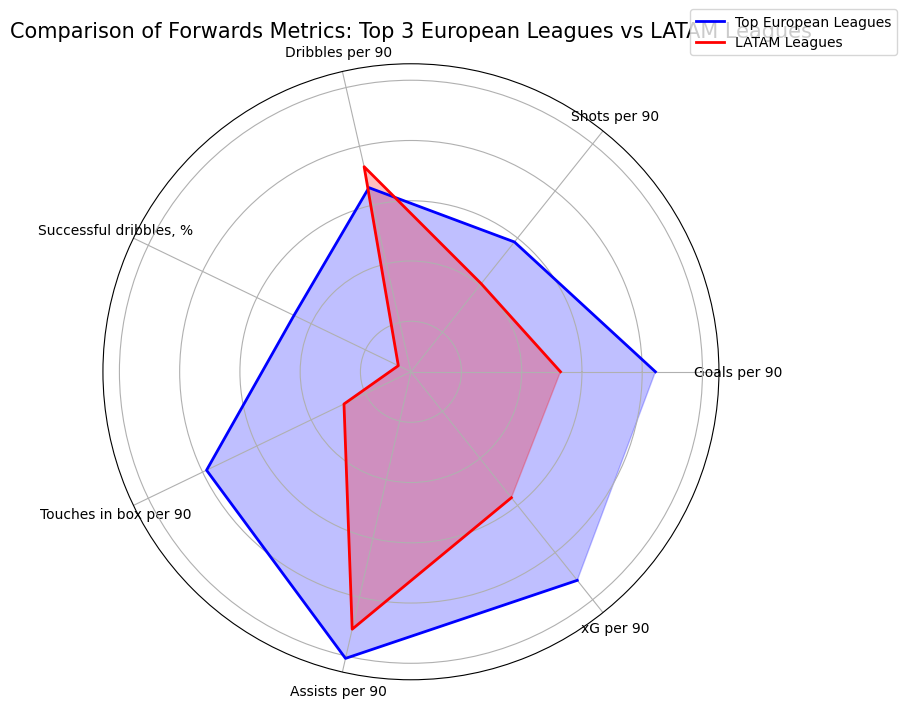

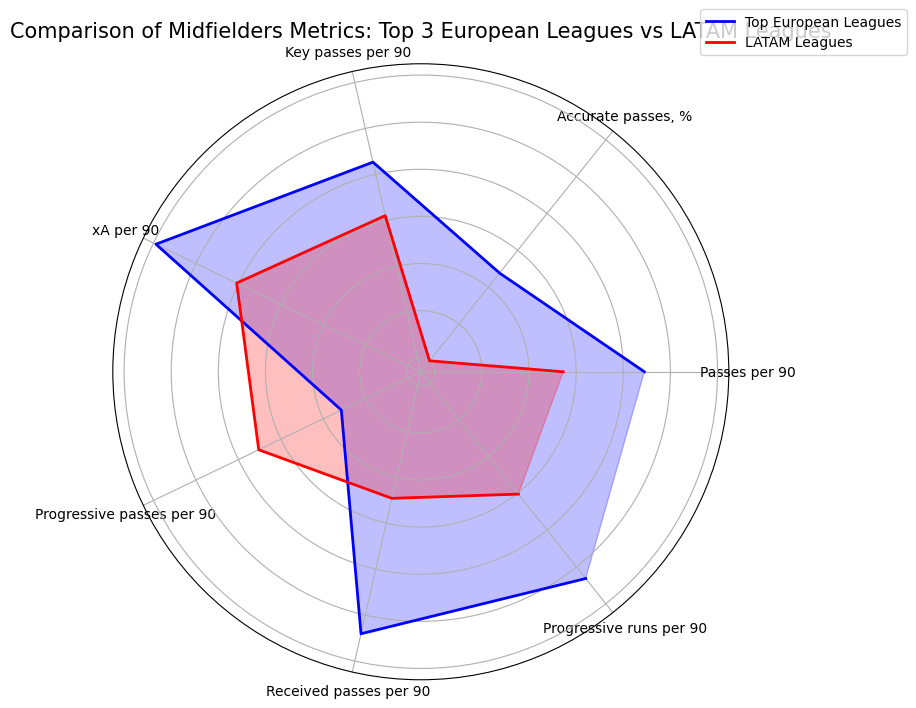

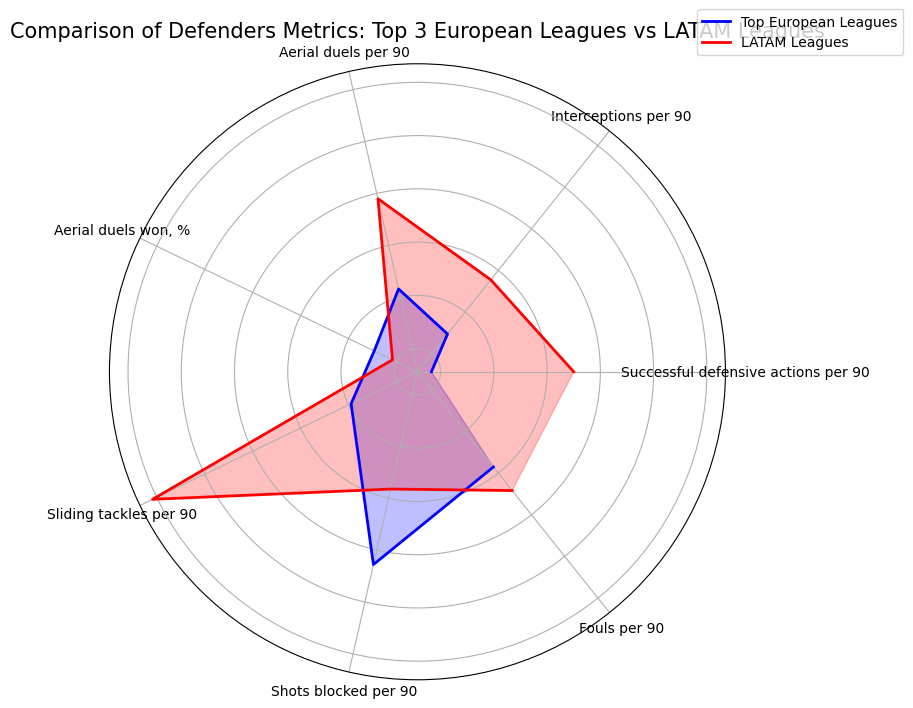

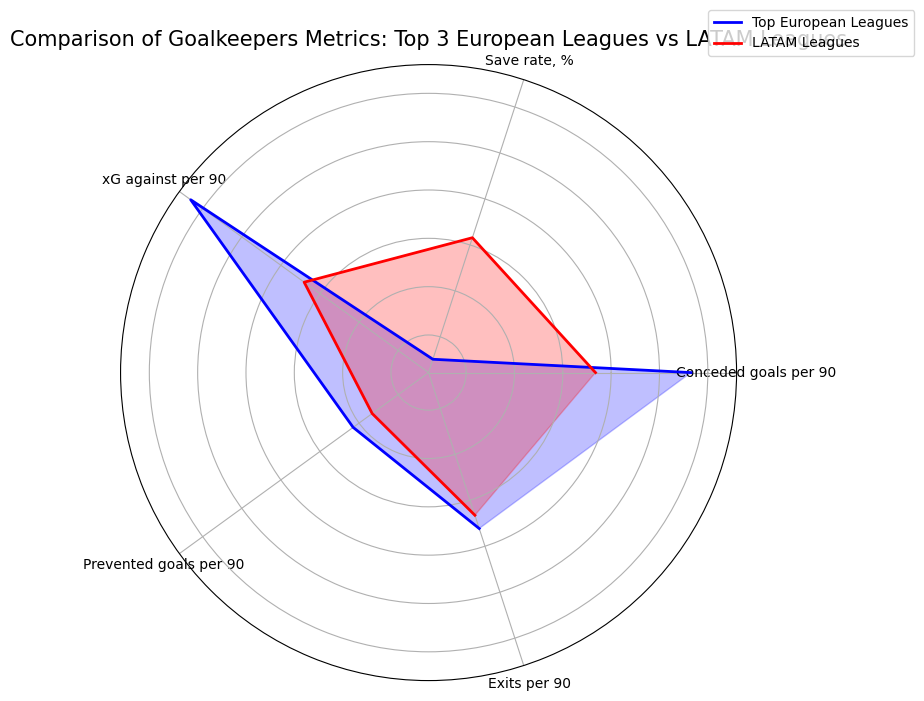

In [44]:
# Create a spider chart for a given position
def plot_spider_chart(df, position, metrics_columns):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Prepare data for each league type
    europe_data = df[df["League"].isin(top_europe_leagues)][metrics_columns].mean()
    latam_data = df[df["League"].isin(latam_leagues)][metrics_columns].mean()

    # Define the number of variables
    num_vars = len(metrics_columns)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Plot data
    ax.fill(angles, europe_data, color='blue', alpha=0.25)
    ax.fill(angles, latam_data, color='red', alpha=0.25)

    # Add lines and labels
    ax.plot(angles, europe_data, color='blue', linewidth=2, label="Top European Leagues")
    ax.plot(angles, latam_data, color='red', linewidth=2, label="LATAM Leagues")

    # Add labels
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(metrics_columns, size=10)
    plt.title(f"Comparison of {position} Metrics: Top 3 European Leagues vs LATAM Leagues", size=15, color='black')
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    plt.show()

# Plot each position's spider chart
plot_spider_chart(forwards_normalized, "Forwards", metrics_columns["forwards"])
plot_spider_chart(midfielders_normalized, "Midfielders", metrics_columns["midfielders"])
plot_spider_chart(defenders_normalized, "Defenders", metrics_columns["defenders"])
plot_spider_chart(goalkeepers_normalized, "Goalkeepers", metrics_columns["goalkeepers"])

### Players that contribute the most to each Position.

In [45]:
# Define the top European and LATAM leagues
top_europe_leagues = ["PremierLeague", "LaLiga", "SerieA"]
latam_leagues = ["LigaMX", "MLS", "ArgentinaLPF"]

def top_contributors_by_group(df, position, metrics_columns, top_n=5):
    """
    Calculates the top contributors within each group (Top 3 European Leagues vs LATAM Leagues) 
    based on normalized data. The function computes a contribution score for each player and 
    returns the top players by group.
    
    Parameters:
    - df (pd.DataFrame): The normalized DataFrame containing player stats.
    - position (str): Position group (e.g., "Forwards", "Midfielders").
    - metrics_columns (list): List of columns to use for calculating contribution.
    - top_n (int): Number of top players to return for each group.
    
    Returns:
    - pd.DataFrame: Top contributors in each group.
    """
    # Split data by league groups
    europe_df = df[df["League"].isin(top_europe_leagues)]
    latam_df = df[df["League"].isin(latam_leagues)]
    
    # Calculate contribution score as the mean of selected metrics for each group
    europe_df["Contribution Score"] = europe_df[metrics_columns].mean(axis=1)
    latam_df["Contribution Score"] = latam_df[metrics_columns].mean(axis=1)
    
    # Get top contributors for each group
    top_europe_contributors = europe_df.sort_values(by="Contribution Score", ascending=False).head(top_n)
    top_latam_contributors = latam_df.sort_values(by="Contribution Score", ascending=False).head(top_n)
    
    # Add group label for clarity
    top_europe_contributors["Group"] = "Top European Leagues"
    top_latam_contributors["Group"] = "LATAM Leagues"
    
    # Concatenate results and select display columns
    display_columns = ["Full name", "Team", "Team within selected timeframe", "Primary position", "Market value", "Contribution Score", "Competition" , "League", "Group"]
    # convert market value to monetary format
    top_europe_contributors["Market value"] = top_europe_contributors["Market value"].apply(lambda x: f"${x:,.0f}")
    top_latam_contributors["Market value"] = top_latam_contributors["Market value"].apply(lambda x: f"${x:,.0f}")
    top_contributors = pd.concat([top_europe_contributors[display_columns], top_latam_contributors[display_columns]])
    
    return top_contributors


In [46]:
# Using each normalized position DataFrame and corresponding metrics columns
forwards_top_contributors = top_contributors_by_group(forwards_normalized, "Forwards", metrics_columns["forwards"])
midfielders_top_contributors = top_contributors_by_group(midfielders_normalized, "Midfielders", metrics_columns["midfielders"])
defenders_top_contributors = top_contributors_by_group(defenders_normalized, "Defenders", metrics_columns["defenders"])
goalkeepers_top_contributors = top_contributors_by_group(goalkeepers_normalized, "Goalkeepers", metrics_columns["goalkeepers"])

C:\Users\emanuel.novelo\AppData\Local\Temp\ipykernel_185968\3177995036.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  europe_df["Contribution Score"] = europe_df[metrics_columns].mean(axis=1)
C:\Users\emanuel.novelo\AppData\Local\Temp\ipykernel_185968\3177995036.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latam_df["Contribution Score"] = latam_df[metrics_columns].mean(axis=1)
C:\Users\emanuel.novelo\AppData\Local\Temp\ipykernel_185968\3177995036.py:25: SettingWithCopyWarning: 
A value is tryi

In [47]:
# Display the top contributors for each position
print("Top contributors for Forwards:")
forwards_top_contributors

Top contributors for Forwards:


,Full name,Team,Team within selected timeframe,Primary position,Market value,Contribution Score,Competition,League,Group
356,Sergio Gómez Martín,Manchester City,Manchester City,LAMF,"$10,000,000",1.703355,Premier League,PremierLeague,Top European Leagues
43,Vinícius José Paixão de Oliveira Júnior,Real Madrid,Real Madrid,CF,"$180,000,000",1.584309,LaLiga,LaLiga,Top European Leagues
252,Jérémy Doku,Manchester City,Manchester City,LAMF,"$65,000,000",1.577975,Premier League,PremierLeague,Top European Leagues
336,Manor Solomon,Tottenham Hotspur,Tottenham Hotspur,LAMF,"$13,000,000",1.569641,Premier League,PremierLeague,Top European Leagues
296,Timo Werner,Tottenham Hotspur,Tottenham Hotspur,LAMF,"$17,000,000",1.354659,Premier League,PremierLeague,Top European Leagues
520,Marcelo Javier Correa,Estudiantes,Santos Laguna,CF,"$1,500,000",1.880927,Copa de la Liga Profesional,LigaMX,LATAM Leagues
821,Emmanuel Iwe,Minnesota United II,Minnesota United,LW,$0,1.608465,MLS Next Pro,MLS,LATAM Leagues
824,Ronald Donkor,New York RB,New York RB,LW,$0,1.546454,MLS,MLS,LATAM Leagues
575,Juan Camilo Hernández Suárez,Columbus Crew,Columbus Crew,CF,"$10,000,000",1.476523,MLS,MLS,LATAM Leagues
572,Denis Bouanga,Los Angeles FC,Los Angeles FC,LWF,"$6,000,000",1.434228,MLS,MLS,LATAM Leagues


In [48]:
print("\nTop contributors for Midfielders:")
midfielders_top_contributors


Top contributors for Midfielders:


,Full name,Team,Team within selected timeframe,Primary position,Market value,Contribution Score,Competition,League,Group
33,Luka Modrić,Real Madrid,Real Madrid,RCMF3,"$6,000,000",2.140335,LaLiga,LaLiga,Top European Leagues
77,Pascal Groß,Brighton,Brighton,LCMF,"$8,000,000",1.909100,Premier League,PremierLeague,Top European Leagues
102,Harvey Elliott,Liverpool,Liverpool,RCMF3,"$35,000,000",1.747426,Premier League,PremierLeague,Top European Leagues
23,Rodrigo Javier De Paul,Atlético Madrid,Atlético Madrid,RCMF3,"$30,000,000",1.605814,La Liga,LaLiga,Top European Leagues
358,Hakan Çalhanoğlu,Internazionale,Internazionale,DMF,"$45,000,000",1.437930,Serie A,SerieA,Top European Leagues
140,Álvaro Fidalgo Fernández,América,América,LCMF,"$8,000,000",1.866876,Liga MX,LigaMX,LATAM Leagues
233,Héctor Miguel Herrera López,Houston Dynamo,Houston Dynamo,LCMF,"$2,800,000",1.713833,MLS,MLS,LATAM Leagues
168,Richard Rafael Sánchez Guerrero,América,América,RCMF,"$6,000,000",1.520374,Liga MX,LigaMX,LATAM Leagues
270,Gastón Brugman Duarte,Los Angeles Galaxy,Los Angeles Galaxy,LCMF,"$2,000,000",1.242282,MLS,MLS,LATAM Leagues
194,Omar Andrés Fernández Frasica,Everton,León,RCMF3,"$1,000,000",1.215859,Primera División,LigaMX,LATAM Leagues


In [49]:
print("\nTop contributors for Defenders:")
defenders_top_contributors


Top contributors for Defenders:


,Full name,Team,Team within selected timeframe,Primary position,Market value,Contribution Score,Competition,League,Group
946,Ahmed Touba,Lecce,Lecce,LCB,"$1,600,000",1.446647,Serie A,SerieA,Top European Leagues
342,James Hill,Bournemouth,Bournemouth,LB,"$2,000,000",1.406109,Premier League,PremierLeague,Top European Leagues
963,Pietro Comuzzo,Fiorentina,Fiorentina,LCB,$0,1.399121,Serie A,SerieA,Top European Leagues
160,Mamadou Mbaye,Cádiz,Cádiz,LCB,"$400,000",1.239974,LaLiga,LaLiga,Top European Leagues
949,Jérôme Boateng,Salernitana,Salernitana,CB,"$400,000",1.235491,Serie A,SerieA,Top European Leagues
1246,Elías Agustín Ramirez,Club Atlético Mitre,Gimnasia La Plata,RWB,$0,2.507106,Primera Nacional,ArgentinaLPF,LATAM Leagues
1244,Álvaro Agustín Lagos,Atlético Tucumán,Atlético Tucumán,RB,"$175,000",2.169053,Liga Profesional de Fútbol,ArgentinaLPF,LATAM Leagues
1241,Pablo Ezequiel Aranda,Lanús Res.,Lanús,RB,$0,2.121551,Reserve League,ArgentinaLPF,LATAM Leagues
1219,Leonel Di Plácido,Botafogo,Lanús,RB,"$500,000",1.862870,Serie A,ArgentinaLPF,LATAM Leagues
778,Ousman Jabang,CF Montréal,CF Montréal,RCB3,$0,1.627827,MLS,MLS,LATAM Leagues


In [50]:
print("\nTop contributors for Goalkeepers:")
goalkeepers_top_contributors


Top contributors for Goalkeepers:


,Full name,Team,Team within selected timeframe,Primary position,Market value,Contribution Score,Competition,League,Group
216,Simone Perilli,Hellas Verona,Hellas Verona,GK,"$200,000",2.398890,Serie A,SerieA,Top European Leagues
38,Jaume Doménech Sánchez,Valencia,Valencia,GK,"$800,000",1.823741,La Liga,LaLiga,Top European Leagues
75,Loris Karius,Newcastle United,Newcastle United,GK,"$1,000,000",1.768737,Premier League,PremierLeague,Top European Leagues
65,Arijanet Murić,Burnley,Burnley,GK,"$7,000,000",1.556083,Premier League,PremierLeague,Top European Leagues
70,Robin Olsen,Aston Villa,Aston Villa,GK,"$1,500,000",1.129541,Premier League,PremierLeague,Top European Leagues
167,James Pantemis,CF Montréal,CF Montréal,GK,"$400,000",1.379058,MLS,MLS,LATAM Leagues
170,Andrew Tarbell,Houston Dynamo,Houston Dynamo,GK,"$150,000",1.037262,MLS,MLS,LATAM Leagues
255,Cristopher Javier Fiermarin Forlán,Defensa y Justicia,Defensa y Justicia,GK,"$300,000",1.002228,Liga Profesional de Fútbol,ArgentinaLPF,LATAM Leagues
171,Thomas Hasal,Vancouver Whitecaps,Vancouver Whitecaps,GK,"$500,000",0.957285,MLS,MLS,LATAM Leagues
107,Héctor Hipólito Holguín Pérez,Santos Laguna,Santos Laguna,GK,"$400,000",0.915153,Liga MX,LigaMX,LATAM Leagues


## Particular player analysis

In [51]:
# Analysis for Rominigue Kouamé N'Guessan, show all his data in midfielders_normalized
midfielders_normalized[midfielders_normalized["Full name"] == "Rominigue Kouamé N'Guessan" ]

,Full name,Team,Team within selected timeframe,Competition,League,Primary position,Age,Market value,Matches played,Minutes played,Foot,Passes per 90,"Accurate passes, %",Key passes per 90,xA per 90,Progressive passes per 90,Received passes per 90,Progressive runs per 90
49,Rominigue Kouamé N'Guessan,Cádiz,Cádiz,LaLiga,LaLiga,RCMF,27,2000000.0,16,931,left,0.084194,0.582386,-0.607143,-0.125,-0.206349,-0.222023,0.41573


## Considerations

Some players may have a high contribution score but we must take into account minutes / matches played, another approach could be to filter only players who have played over certain amount of matches and/or minutes.
Antoher important consideration is that at first the Min Max scaler was used to standarize the variables, but then it was changed to Robust Scaler.

## Conclusions

To conclude the analysis, we can observe in general that Top 3 Europe leagues tend to have higher performance in almost every aspect of the game compared to LATAM leagues. This is evident in the aggregated metrics, the spider charts, and the top contributors' analysis.

### Highlights by Position Group - Personal perspective

#### Forwards:

- European forwards tend to excel in metrics related to offensive effectiveness, especially in shots per 90, goals per 90, and touches in the box per 90, reflecting a more aggressive attacking approach.
- LATAM forwards show strengths in successful dribbles percentage, indicating technical proficiency in one-on-one situations. However, they lag in metrics tied directly to goal-scoring efficiency, such as xG (expected goals) and shots per 90.

#### Midfielders:

- European midfielders outperform in key passing metrics, including key passes per 90 and passes per 90, suggesting a structured playmaking style with high passing accuracy.
- LATAM midfielders demonstrate relatively high progressive passes, highlighting creative contributions despite fewer overall passes, which may imply a more direct style with lower possession but impactful plays.

#### Defenders:

- LATAM defenders show higher averages in aerial duels per 90, Sliding tackles and successful defensive actions, emphasizing a physical style with more focus on defensive actions. But also high proportion of Fouls.
- European defenders excel in intercepting and blocking metrics, showing a more controlled and tactical approach, which aligns with the structured defensive systems often seen in top European leagues.

#### Goalkeepers:

- European goalkeepers lead in metrics related Prevented goals and Exits, but also have a higher Conceded goals and xG against (Expected goals against).
- LATAM goalkeepers, excel in Save rate %, even having conceded fewwer goals.

#### Overall Summary:

- European leagues generally focus on metrics that reflect structured, possession-based play, with high performance in passing, goal-scoring efficiency, and defensive positioning.
- LATAM leagues display a more direct and physically engaging style, with strengths in dribbling, aerial duels, and creative assists, though they may be less efficient in metrics that benefit from structured tactics or defensive depth.

## What's next

1. A lot of different configurations in the analysis can be made, particularly with the selection of main variables and the scaler method.
2. Further and deeper analysis must be made in regard to data quality, since observations may still have issues to resolve.